In [45]:
# imports
import os
import pandas as pd
import numpy as np
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from sktime.distances import dtw_distance

# graphing backend
pd.options.plotting.backend = "plotly"

In [18]:
# load in data
data = pd.DataFrame()

for file in os.listdir():
    if 'coin' in file:
        tmp = pd.read_csv(file)
        coin = file.split('_')[1][:-4]
        data[coin] = tmp['Close']
        
# head of data
data.head()

,NEM,EOS,Monero,Polkadot,USDCoin,Uniswap,BinanceCoin,Iota,Aave,Solana,...,Cosmos,ChainLink,Litecoin,XRP,Ethereum,Tron,Stellar,CryptocomCoin,Dogecoin,WrappedBitcoin
0,0.000314,2.71005,2.09558,2.875028,1.00686,6.897257,0.105138,0.528916,53.219243,0.776819,...,7.504351,0.169680,4.38390,0.005613,0.753325,0.001427,0.002657,0.017243,0.000205,3466.506533
1,0.000310,4.08664,2.96302,4.484690,1.00962,5.724464,0.107737,0.363661,42.401599,0.882507,...,7.383882,0.150503,4.29649,0.004680,0.701897,0.001801,0.002501,0.015301,0.000269,3480.772314
2,0.000277,3.37200,3.70245,3.967066,1.00978,5.244195,0.104067,0.410757,40.083976,0.777832,...,4.776164,0.131129,3.80101,0.004417,0.708448,0.001831,0.002881,0.014448,0.000362,3542.095361
3,0.000232,3.00323,3.13856,4.602614,1.01272,4.266079,0.107811,0.419906,43.764463,0.661925,...,5.110341,0.170278,3.37198,0.004254,1.067860,0.003320,0.003481,0.016260,0.001162,3477.866026
4,0.000289,3.36133,3.02186,5.523393,1.00743,3.905138,0.106414,0.405862,46.817744,0.646651,...,4.821883,0.182198,3.04491,0.004291,1.217440,0.003263,0.004303,0.020790,0.000704,3481.219346


In [20]:
# null values
data.isnull().sum()

NEM                  0
EOS                822
Monero               0
Polkadot          1968
USDCoin           1286
Uniswap           1996
BinanceCoin        846
Iota               804
Aave              2013
Solana            1836
Bitcoin              0
Cardano            914
Tether               0
Cosmos            1443
ChainLink          903
Litecoin             0
XRP                  0
Ethereum           128
Tron               896
Stellar              0
CryptocomCoin     1353
Dogecoin             0
WrappedBitcoin    1400
dtype: int64

In [21]:
# only include coins with no missing values
mask = data.isnull().sum() == 0
mkt = data.loc[:, mask]
mkt.head()

,NEM,Monero,Bitcoin,Tether,Litecoin,XRP,Stellar,Dogecoin
0,0.000314,2.09558,144.539993,1.205740,4.38390,0.005613,0.002657,0.000205
1,0.000310,2.96302,139.000000,0.606502,4.29649,0.004680,0.002501,0.000269
2,0.000277,3.70245,116.989998,0.606229,3.80101,0.004417,0.002881,0.000362
3,0.000232,3.13856,105.209999,1.000000,3.37198,0.004254,0.003481,0.001162
4,0.000289,3.02186,97.750000,1.000000,3.04491,0.004291,0.004303,0.000704


In [23]:
# create a matrix of log returns
mkt_returns = np.log(mkt).diff().iloc[1:]

# look at the overall data
mkt_returns.corr()

,NEM,Monero,Bitcoin,Tether,Litecoin,XRP,Stellar,Dogecoin
NEM,1.000000,0.026048,0.002445,-0.036327,0.008505,0.032437,-0.000475,-0.021760
Monero,0.026048,1.000000,0.001847,-0.116546,0.027980,-0.024499,-0.015113,-0.039972
Bitcoin,0.002445,0.001847,1.000000,-0.014786,0.659603,-0.026232,-0.047327,-0.027861
Tether,-0.036327,-0.116546,-0.014786,1.000000,-0.017817,0.039076,0.039998,0.126369
Litecoin,0.008505,0.027980,0.659603,-0.017817,1.000000,-0.040766,-0.029558,-0.018392
XRP,0.032437,-0.024499,-0.026232,0.039076,-0.040766,1.000000,0.008031,-0.019511
Stellar,-0.000475,-0.015113,-0.047327,0.039998,-0.029558,0.008031,1.000000,0.036236
Dogecoin,-0.021760,-0.039972,-0.027861,0.126369,-0.018392,-0.019511,0.036236,1.000000


In [28]:
# heatmap
px.imshow(mkt_returns.corr(), text_auto = True)

In [40]:
# unsupervised detection of crypto clusters
U, S, V = np.linalg.svd(mkt_returns)

fig = go.Figure()

fig.add_trace(go.Scatter(x = V[0, :], y = V[1, :], 
                         text = mkt_returns.columns.tolist(),
                         mode = 'markers+text'))

fig.update_layout(title = "Primary Axes of Variance for CrytpoCurrency")

In [57]:
# again, this time with Dynamic Time Warping
dtw_matrix = np.zeros(V.shape)

for i in range(8):
    for j in range(8):
        dtw_matrix[i, j] = dtw_distance(V[i, :], V[j, :])
        
# look again at clusters
U, S, V = np.linalg.svd(dtw_matrix)

fig = go.Figure()

fig.add_trace(go.Scatter(x = V[0, :], y = V[1, :], 
                         text = mkt_returns.columns.tolist(),
                         mode = 'markers+text'))

fig.update_layout(title = "Primary Axes of Variance for CrytpoCurrency Using DTW")

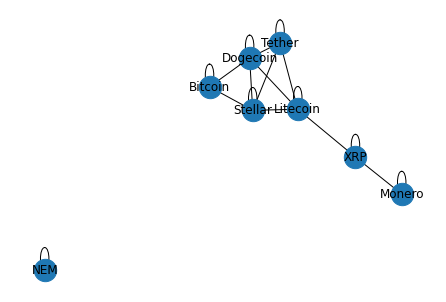

In [85]:
# Create a network graph from DTW data
import matplotlib.pyplot as plt

D = np.where(dtw_matrix <= 1, 1, 0)

def make_label_dict(labels):
    l = {}
    for i, label in enumerate(labels):
        l[i] = label
    return l

def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500, labels=mylabels, with_labels=True)
    plt.show()
    
show_graph_with_labels(D, make_label_dict(mkt.columns.tolist()))